## Анализ временных рядов и предсказание количества поездок на неделю вперед

В этом ноутбуке данные группируется по количеству поездок за день, проводится анализ полученного временного ряда, делаются предсказания количества поездок на неделю вперед.

In [1]:
import scipy as sps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error as MSE

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
import gc
#from fbprophet import Prophet

import warnings

warnings.filterwarnings('ignore')
sns.set(font_scale=1.5)

Загрузим данные о поездках.

In [2]:
trips = pd.read_csv('cycle-share-dataset/trip.csv', error_bad_lines=False,
                   parse_dates=[1, 2])

b'Skipping line 50794: expected 12 fields, saw 20\n'


In [3]:
trips.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1960.0
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1970.0
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1988.0
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Female,1977.0
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Member,Male,1971.0


## Глава 1. Анализ временных рядов

### 1. Кол-во поездок в зависимости от даты

Отобразим количество поездок в зависимости от даты.

Преобразуем сначала данные для удобства подсчёта.

In [4]:
time_data = trips[['trip_id', 'starttime', 'stoptime']].copy()

time_data['start_year'] = time_data['starttime'].dt.year
time_data['start_month'] = time_data['starttime'].dt.month
time_data['start_day'] = time_data['starttime'].dt.day
time_data['start_date'] = time_data['starttime'].dt.date
time_data['start_time'] = time_data['starttime'].dt.time
time_data['start_weekday'] = time_data['starttime'].dt.dayofweek

time_data['stop_year'] = time_data['stoptime'].dt.year
time_data['stop_month'] = time_data['stoptime'].dt.month
time_data['stop_day'] = time_data['stoptime'].dt.day
time_data['stop_date'] = time_data['stoptime'].dt.date
time_data['stop_time'] = time_data['stoptime'].dt.time
time_data['stop_weekday'] = time_data['stoptime'].dt.dayofweek

time_data.drop(columns=['starttime', 'stoptime'], inplace=True)

time_data.head()

,trip_id,start_year,start_month,start_day,start_date,start_time,start_weekday,stop_year,stop_month,stop_day,stop_date,stop_time,stop_weekday
0,431,2014,10,13,2014-10-13,10:31:00,0,2014,10,13,2014-10-13,10:48:00,0
1,432,2014,10,13,2014-10-13,10:32:00,0,2014,10,13,2014-10-13,10:48:00,0
2,433,2014,10,13,2014-10-13,10:33:00,0,2014,10,13,2014-10-13,10:48:00,0
3,434,2014,10,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:48:00,0
4,435,2014,10,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:49:00,0


In [5]:
trips_by_date = time_data.groupby('start_date').count()['trip_id']

trips_by_date

start_date
2014-10-13    818
2014-10-14    982
2014-10-15    626
2014-10-16    790
2014-10-17    588
             ... 
2016-08-27    333
2016-08-28    392
2016-08-29    369
2016-08-30    375
2016-08-31    319
Name: trip_id, Length: 689, dtype: int64

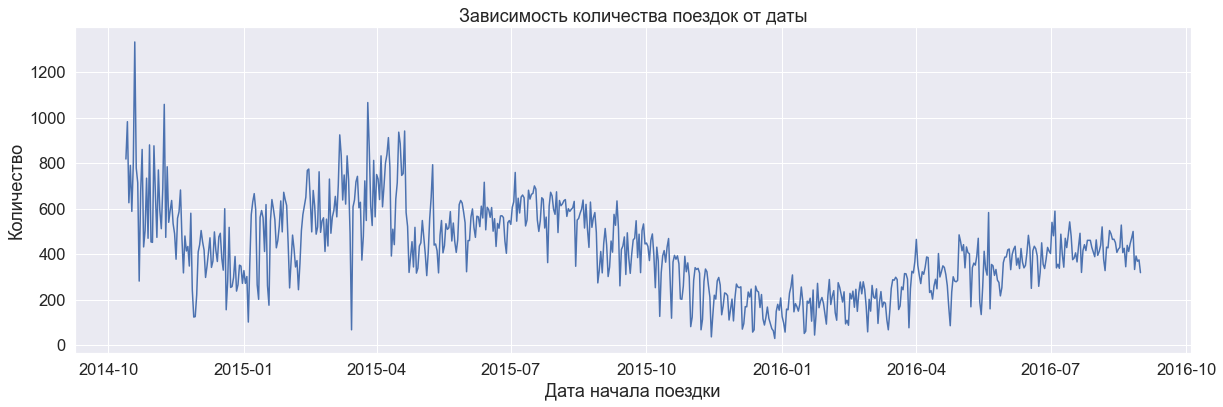

In [8]:
plt.figure(figsize=(20, 6))
sns.set_style('darkgrid')

plt.title('Зависимость количества поездок от даты')

plt.plot(trips_by_date.index, trips_by_date)
plt.xlabel('Дата начала поездки')
plt.ylabel('Количество')

plt.show()

**Наблюдения:** видно что в зависимости от даты у кол-ва поездок меняется дисперсия. Также на многих промежутках времени явно прослеживается тренд, поэтому скорее всего ряд не стационарен

### 2. Стационарность

Проверим ряд на стационарность с помощью критерия KPSS.

In [9]:
kpss(trips_by_date)

(1.5431653515342676,
 0.01,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

***Наблюдение***

Гипотеза о стационарности отверглась. Значит, имеет смысл исследовать ряд на тренд и сезонность. 

### 3. STL-декомпозиция

Применим STL-декомпозицию к полученному временному ряду.

In [20]:
decomposed = seasonal_decompose(trips_by_date, freq=30)

day_decomp = seasonal_decompose(trips_by_date, freq=7)

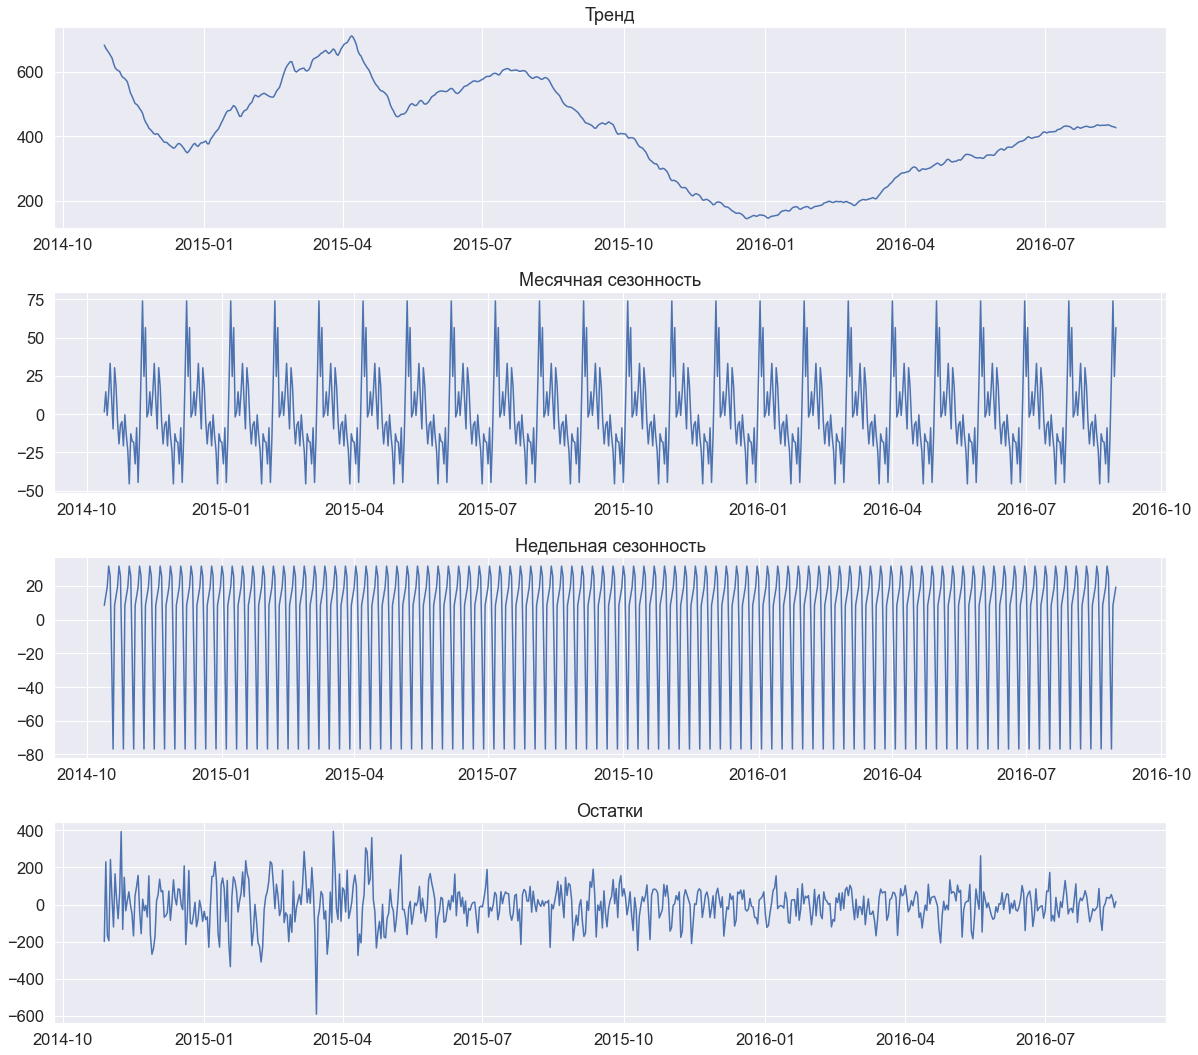

In [21]:
plt.figure(figsize=(17, 15))

plt.subplot(411)
plt.plot(trips_by_date.index, decomposed.trend)
plt.title('Тренд')

plt.subplot(412)
plt.plot(trips_by_date.index, decomposed.seasonal)
plt.title('Месячная сезонность')

plt.subplot(413)
plt.plot(trips_by_date.index, day_decomp.seasonal)
plt.title('Недельная сезонность')

plt.subplot(414)
plt.plot(trips_by_date.index, decomposed.resid)
plt.title('Остатки')

plt.tight_layout()

***Наблюдение***


На графиках отчётливо прослеживается недельная и месячная сезонность. Исследовать годовую сезоннность с помощью декомпозиции не представляется возможным, т.к. в датасете нет данных за полных два года.

### 4. Автокорреляция

Построим теперь графики автокорреляций для продифференцированного ряда, т.к. в данных, очевидно, наблюдается и тренд, и сезонность.

Для удаления тренда и всех сезонностей продифференцируем ряд несколько раз.

In [77]:
diff =  trips_by_date.values[1:] - trips_by_date.values[:-1]
month_diff = diff[30:] - diff[:-30]
week_diff = month_diff[7:] - month_diff[:-7]

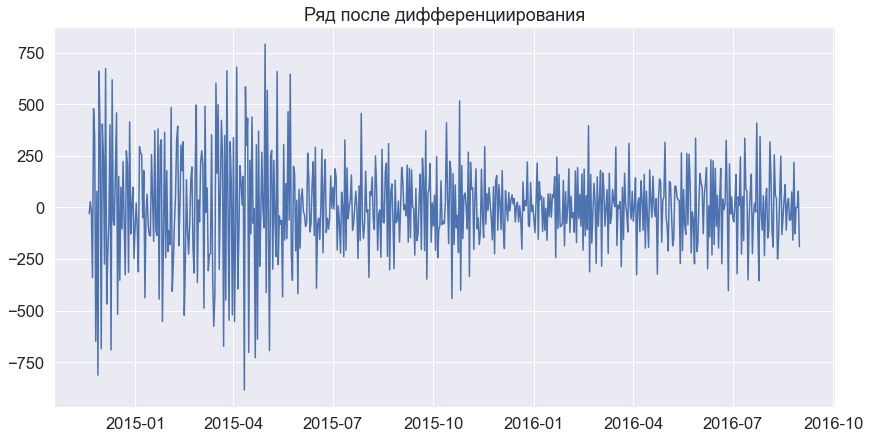

In [91]:
plt.figure(figsize=(14, 7))
plt.title('Ряд после дифференциирования')
plt.plot(trips_by_date.index.values[38:], week_diff)
plt.show()

**Наблюдение:** тренд и сезонность кажется убраны, но дисперсия все равно не стабильна.

Проверим гипотезу о стационариности.

In [92]:
kpss(week_diff)

(0.022038395790409795,
 0.1,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Как видим теперь гипотеза о стационарности не отвергается

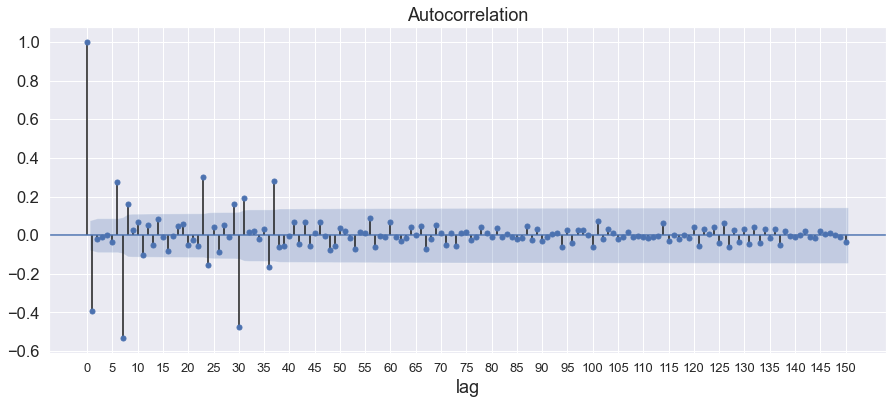

In [93]:
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(week_diff, lags=150, ax=ax)
ax.set_xticks(np.arange(0, 151, 5))

plt.setp(ax.get_xticklabels(), fontsize=13)
ax.set_xlabel('lag')

plt.show()

***Вывод***

Значимыми оказались лаги 1, 6, 7, 23, 24, 30, 36, 37. Значения 7 и 30 учитывать не стоит, т.к. дифференцирование могло "снять" не всю сезонность. Остальные результаты помогут в подборе параметров предсказательных моделей. Таких, как, например, ARIMA.

## Глава 2. Предсказание поездок на неделю вперёд

### 0. Разбиение данных

Разобьем поездки на интервалы по 30 минут.

In [6]:
time_data.head()

,trip_id,start_year,start_month,start_day,start_date,start_time,start_weekday,stop_year,stop_month,stop_day,stop_date,stop_time,stop_weekday
0,431,2014,10,13,2014-10-13,10:31:00,0,2014,10,13,2014-10-13,10:48:00,0
1,432,2014,10,13,2014-10-13,10:32:00,0,2014,10,13,2014-10-13,10:48:00,0
2,433,2014,10,13,2014-10-13,10:33:00,0,2014,10,13,2014-10-13,10:48:00,0
3,434,2014,10,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:48:00,0
4,435,2014,10,13,2014-10-13,10:34:00,0,2014,10,13,2014-10-13,10:49:00,0


In [7]:
def time_round(s):
    if int(s[0]) >= 3:
        return '30'
    else:
        return '00'

time_data.start_time = time_data.start_time.values.astype(str)
time_data['time'] = [str(day) + ' ' + s[0:3] + time_round(s[3:4]) + ':00' 
                     for s, day in zip(time_data.start_time.values, time_data.start_date.values)]

In [8]:
time_data['time'] = [pd.to_datetime(s) for s in time_data.time.values]

In [9]:
series = time_data.groupby('time').count()['trip_id'].to_frame()

In [10]:
series['count'] = series.trip_id
series = series.drop(columns=['trip_id'])

In [11]:
series

,count
time,
2014-10-13 10:30:00,12
2014-10-13 11:30:00,108
2014-10-13 12:00:00,42
2014-10-13 12:30:00,42
2014-10-13 13:00:00,36
...,...
2016-08-31 21:00:00,3
2016-08-31 21:30:00,2
2016-08-31 22:00:00,4


Будем предсказывать кол-во взятых в прокат велосипедов на неделю вперед по данным за последние полгода. Понятно, что так мы сможем учесть и месячную, и недельную сезонность, в то же время мы не можем ничего говорить о годовой сезонности, поэтому данные почти за два года будут излишними, более того, из-за них можно будет не уследить за краткосрочным трендом.

In [12]:
test_size = 48*7
train_size = 48*30*6
train = series.tail(test_size + train_size).head(train_size)
test = series.tail(test_size)

Взглянем на ряд

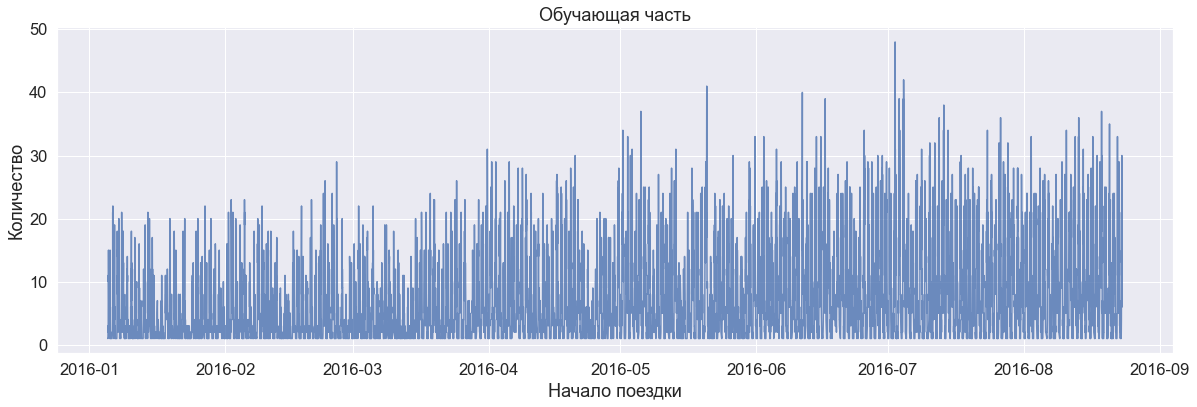

In [13]:
plt.figure(figsize=(20, 6))
sns.set_style('darkgrid')

plt.title('Обучающая часть')

plt.plot(train.index, train['count'].values, alpha=0.8)
plt.xlabel('Начало поездки')
plt.ylabel('Количество')

plt.show()

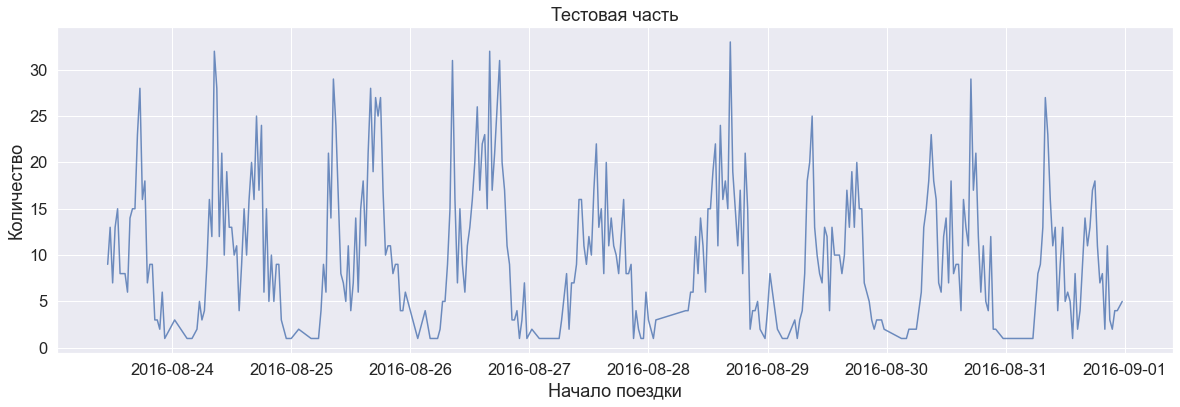

In [14]:
plt.figure(figsize=(20, 6))
sns.set_style('darkgrid')

plt.title('Тестовая часть')

plt.plot(test.index, test['count'].values, alpha=0.8)
plt.xlabel('Начало поездки')
plt.ylabel('Количество')

plt.show()

### 1. Бейзлайны - среднее и последнее наблюдаемое значение.

Во временных рядах сильными бейзлайнами являются среднеее и последнее наблюдаемое значение. Благодаря ним поймем, на какой MSE стоит ориентироваться.

In [15]:
mean_preds = np.array([train['count'].mean()] * test_size)

In [16]:
def print_preds(test, preds, name):
    plt.figure(figsize=(20, 6))
    sns.set_style('darkgrid')

    plt.title('Тестовая часть и предсказания')

    plt.plot(test.index, test['count'].values, alpha=0.8,
             label='test')
    plt.plot(test.index, preds, alpha=0.9,
             label=name + ' preds')
    plt.xlabel('Начало поездки')
    plt.ylabel('Количество')
    plt.legend()
    plt.show()

MSE = 58.514083956434945


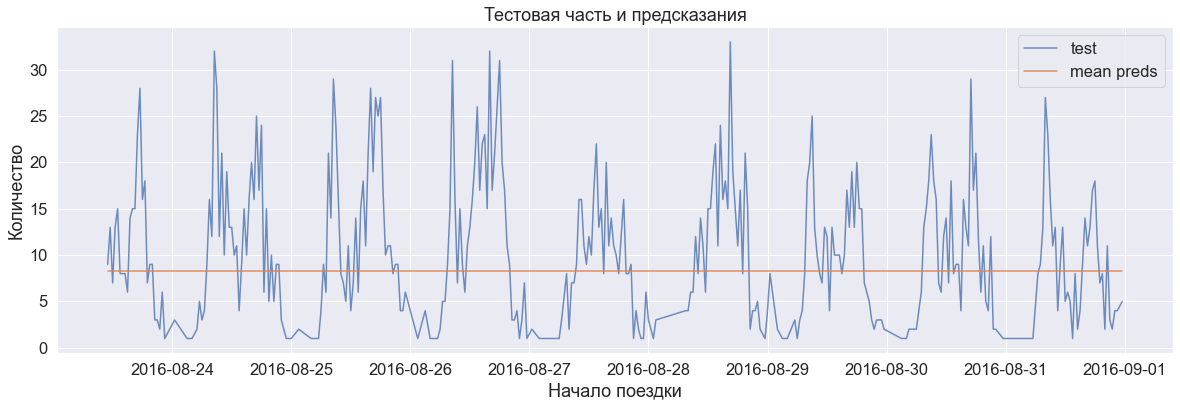

In [17]:
mse = MSE(test['count'].values, mean_preds)
print(f'MSE = {mse}')
print_preds(test, mean_preds, name='mean')

MSE = 72.96130952380952


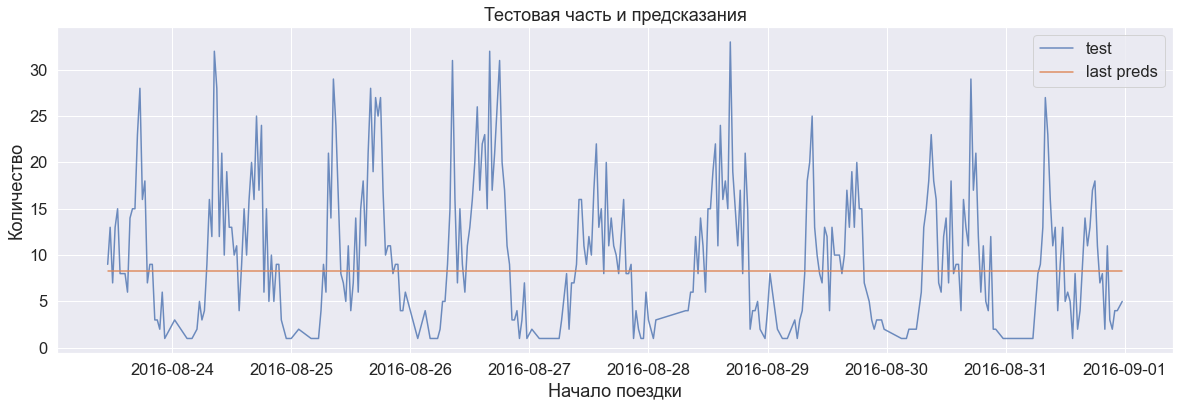

In [18]:
last_preds = np.array([train['count'].values[-1]] * test_size)
mse = MSE(test['count'].values, last_preds)
print(f'MSE = {mse}')
print_preds(test, mean_preds, name='last')

Пока будем равняться на бейзлайн средних предсказаний

### 2. Подбор параметров для SARIMA

Из анализа проведенного выше понятно, что есть месячная и недельная сезонность. Рассмотрим дневную.

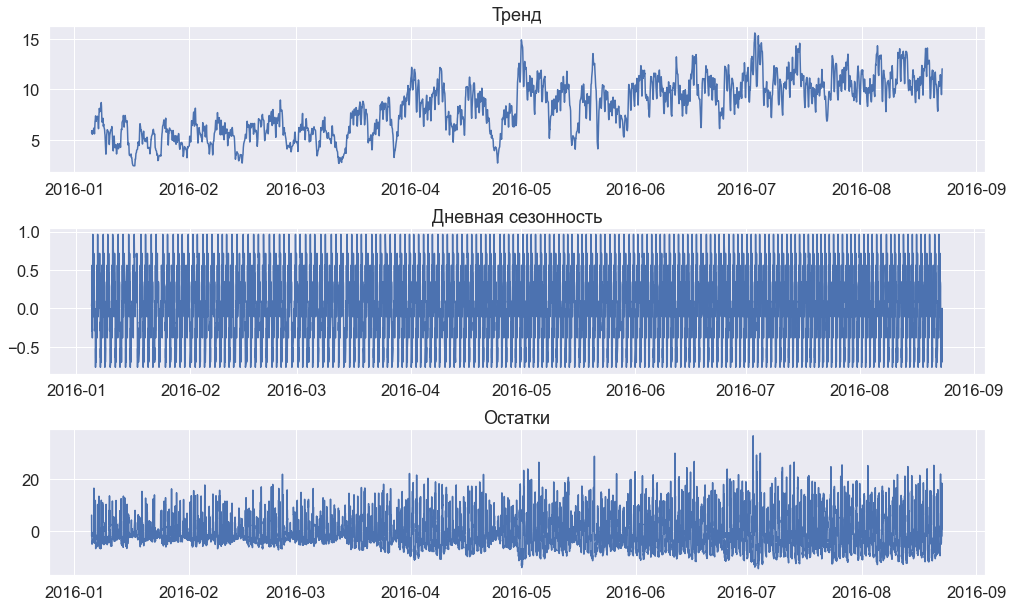

In [19]:
gc.collect()
decomposed = seasonal_decompose(train['count'].values, freq=48)

plt.figure(figsize=(14, 11))

plt.subplot(411)
plt.plot(train.index, decomposed.trend)
plt.title('Тренд')

plt.subplot(412)
plt.plot(train.index, decomposed.seasonal)
plt.title('Дневная сезонность')

plt.subplot(413)
plt.plot(train.index, decomposed.resid)
plt.title('Остатки')

plt.tight_layout()

Дневная сезонность действительно очевидна.

Для подбора параметров для SARIMA нужно смотреть на значимые лаги коррелограммы после приведения ряда к стационарному.

In [20]:
train_count = train['count'].values

In [21]:
kpss(train_count)

(13.559720625081978,
 0.01,
 37,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Как видим, пока что гипотеза о стационарности отвергается

In [22]:
diff = train_count[1:] - train_count[:(-1)]  # снимаем тренд
diff = diff[(48*30):] - diff[:(-48*30)]
diff = diff[(48*7):] - diff[:(-48*7)]
diff = diff[(48):] - diff[:(-48)]

In [23]:
kpss(diff)

(0.005546095525755831,
 0.1,
 35,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Теперь не отвергается

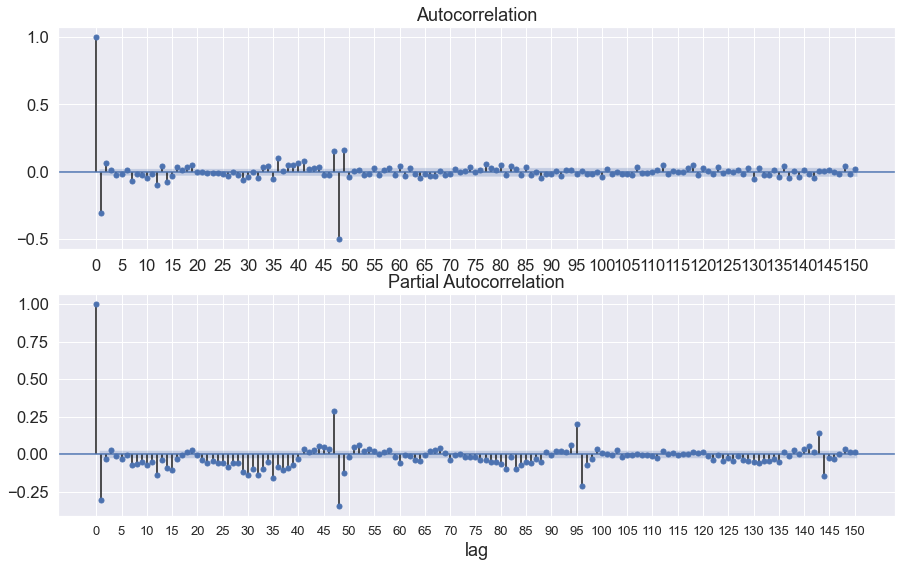

In [24]:
fig = plt.figure(figsize=(15, 9))

ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, lags=150, ax=ax)
ax.set_xticks(np.arange(0, 151, 5))

ax = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff, lags=150, ax=ax)
ax.set_xticks(np.arange(0, 151, 5))

plt.setp(ax.get_xticklabels(), fontsize=13)
ax.set_xlabel('lag')

plt.show()

**Результат:** автокорреляция принимает большие значения для первых 2-х лагов, поэтому
возьмем p = 2. Частичная автокоррреляция принимает большие значения для первых трех
лагов, поэтому возьмем q = 3. На лаги, соответствующие сезонности, не обращаем внимание, так как дифференциируемость не обязательнос снимает всю сезонность.

### 3. Обучение SARIMAX

In [25]:
%%time
param = (2, 1, 3)
param_seasonal = (2, 1, 2, 48)
model = sm.tsa.statespace.SARIMAX(train_count, order=param,
                                  seasonal_order=param_seasonal)
model = model.fit()
print('ARIMA{}x{} – AIC: {:.2f}'.format(param,
                                        param_seasonal,
                                        model.aic))

ARIMA(2, 1, 3)x(2, 1, 2, 48) – AIC: 50710.26
Wall time: 1h 43s


In [30]:
train_count.shape

(8640,)

In [35]:
preds = model.predict(start=0, end=8640, dynamic=True)

MemoryError: 

In [ ]:
preds

MSE = 109.65788942323996


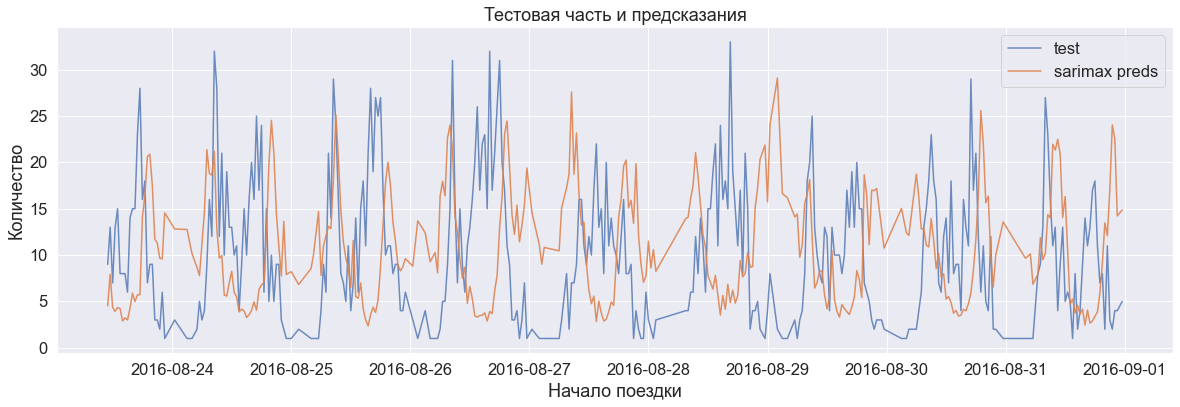

In [71]:
mse = MSE(test['count'].values, preds)
print(f'MSE = {mse}')
print_preds(test, preds, name='sarimax')

### 4. fb prophet